In [81]:
import numpy as np
import matplotlib.pyplot as plt
from worldModels import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [139]:
def make_switching_world(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorld(rates=rates, ntrials=ntrials)
    return world

def make_switching_world_withCheck(rlow, rhigh, nblocks, ntrialsLow, ntrialsHigh):
    ratesL = (np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    ratesR = (1 - np.mod(np.arange(nblocks), 2)) * (rhigh - rlow) + rlow
    if np.random.rand() > 0.5:
        rates = np.vstack((ratesL, ratesR)).T
    else:
        rates = np.vstack((ratesR, ratesL)).T
    ntrials = np.random.uniform(low=ntrialsLow, high=ntrialsHigh, size=nblocks).astype('int')
    world = PersistentWorldWithCheck(rates=rates, ntrials=ntrials, threshold=0.8)
    return world

def errorsigmoid(p, x, y):
    '''
    Error function used for sigmoid fitting
    '''
    preds = 1 / (1 + np.exp(-p[0] * (x + p[1])))
    return np.sum((preds - y)**2)

In [338]:
pswitchlst = np.linspace(0.01, 0.3, 25)
prewlst = np.linspace(0.5, 0.99, 20)
N_iters = 50
num_states = 2
obs_dim = 1
T11lst = np.zeros((len(pswitchlst), len(prewlst)))
T22lst = np.zeros((len(pswitchlst), len(prewlst)))
E1lst = np.zeros((len(pswitchlst), len(prewlst)))
E2lst = np.zeros((len(pswitchlst), len(prewlst)))
efflist = np.zeros((len(pswitchlst), len(prewlst)))
PRslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PLslopelist = np.zeros((len(pswitchlst), len(prewlst)))
PRoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))
PLoffsetlist = np.zeros((len(pswitchlst), len(prewlst)))


for idsw, psw in enumerate(pswitchlst):
    print(psw)
    for idrew, prew in enumerate(prewlst):
        world = make_switching_world_withCheck(0, 1, 100, 15, 25)
        agent = InferenceBasedAgent(prew=prew, pswitch=psw, type='random')
        exp = Experiment(agent, world)
        exp.run()  
        
        # Fit HMM to choice sequence
        data = np.array(agent.choice_history)[:,None] 

        ## testing the constrained transitions class
        hmm = ssm.HMM(num_states, obs_dim, observations="bernoulli")
        hmm_lls = hmm.fit(data, method="em", num_iters=N_iters, init_method="kmeans", verbose=0)
        
        ## Sigmoidal fit for choice transitions
        pR, pL = find_LR_transition_fit(world, agent, window=10)

        efflist[idsw][idrew] = agent.find_efficiency()
        T11lst[idsw][idrew] = hmm.transitions.transition_matrix[0][0]
        T22lst[idsw][idrew] = hmm.transitions.transition_matrix[1][1]
        E1lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[0]
        E2lst[idsw][idrew] = logistic(hmm.observations.logit_ps)[1]
        PRslopelist[idsw][idrew] = pR[0]
        PLslopelist[idsw][idrew] = pL[0]
        PRoffsetlist[idsw][idrew] = pR[1]
        PLoffsetlist[idsw][idrew] = pL[1]
        
        
    
                  

0.01


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


0.022083333333333333


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


0.034166666666666665


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


0.04625


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.058333333333333334


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.07041666666666667


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.08249999999999999


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.09458333333333332


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.10666666666666666


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.11875


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.13083333333333333


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.14291666666666666


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.155


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.16708333333333333


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.17916666666666667


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.19125


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.20333333333333334


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.21541666666666667


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.2275


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.23958333333333334


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.25166666666666665


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.26375


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.2758333333333333


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.28791666666666665


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

0.3


/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret

In [301]:
side_history = np.array(world.side_history)[:,0]
blocktrans = np.where(np.diff(side_history))[0][:-1]
window = 10

# Get the choices around the transition
choicelst = []
for i in range(window):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])

choicelst = np.array(choicelst)

In [336]:
PRoffsetlist

array([[-1.99088038, -2.01034809, -2.02879205, -2.02043506],
       [-2.05613917, -1.94044825, -2.0161036 , -2.0136703 ],
       [-1.95625691, -1.98748331, -2.12481244, -1.96513629],
       [-2.04947289, -2.02858583, -2.01105762, -2.00359356]])

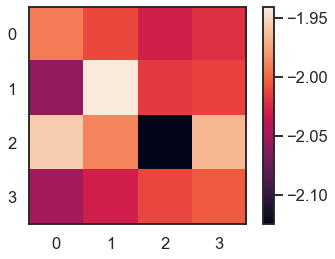

In [337]:
plt.imshow(PRoffsetlist)
plt.colorbar()

/Users/minhnhatle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


Text(0.5, 1.0, 'Action probability (right)')

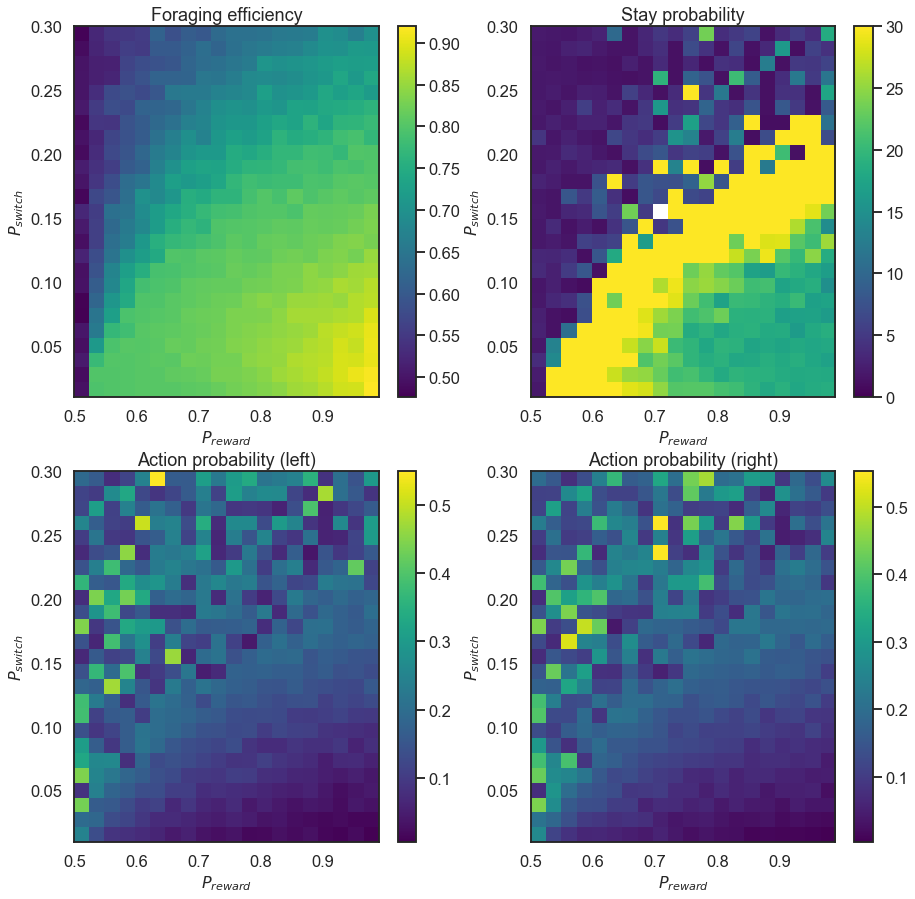

In [339]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(efflist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Foraging efficiency')


# Plot of transition probability
plt.subplot(222)
plt.imshow(1 / (1-T11lst), aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
           vmin=0, vmax=30
          )
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Stay probability')

plt.subplot(223)
plt.imshow(1-np.maximum(E1lst, E2lst), aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Action probability (left)')


plt.subplot(224)
plt.imshow(np.minimum(E1lst, E2lst), aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)])
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Action probability (right)')


In [188]:
PRslopelist

array([[ 2.50976991,  2.50976991, -1.99184786, -1.99184786],
       [-1.99184786,  2.50976991,  2.50976991, -1.99184786],
       [ 2.50976991,  2.50976991,  2.50976991,  2.50976991],
       [-1.99184786, -1.99184786,  2.50976991,  2.50976991]])

In [189]:
PLslopelist

array([[-1.99184786, -1.99184786,  2.50976991,  2.50976991],
       [ 2.50976991, -1.99184786, -1.99184786,  2.50976991],
       [-1.99184786, -1.99184786, -1.99184786, -1.99184786],
       [ 2.50976991,  2.50976991, -1.99184786, -1.99184786]])

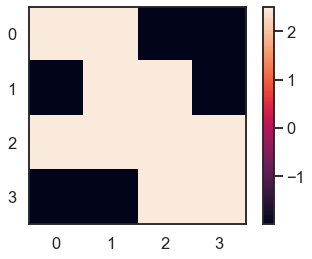

In [187]:
plt.imshow(PRslopelist)
plt.colorbar()

In [178]:
np.min(PLoffsetlist)

-2.2787473734151047

Text(0.5, 1.0, 'Left slope')

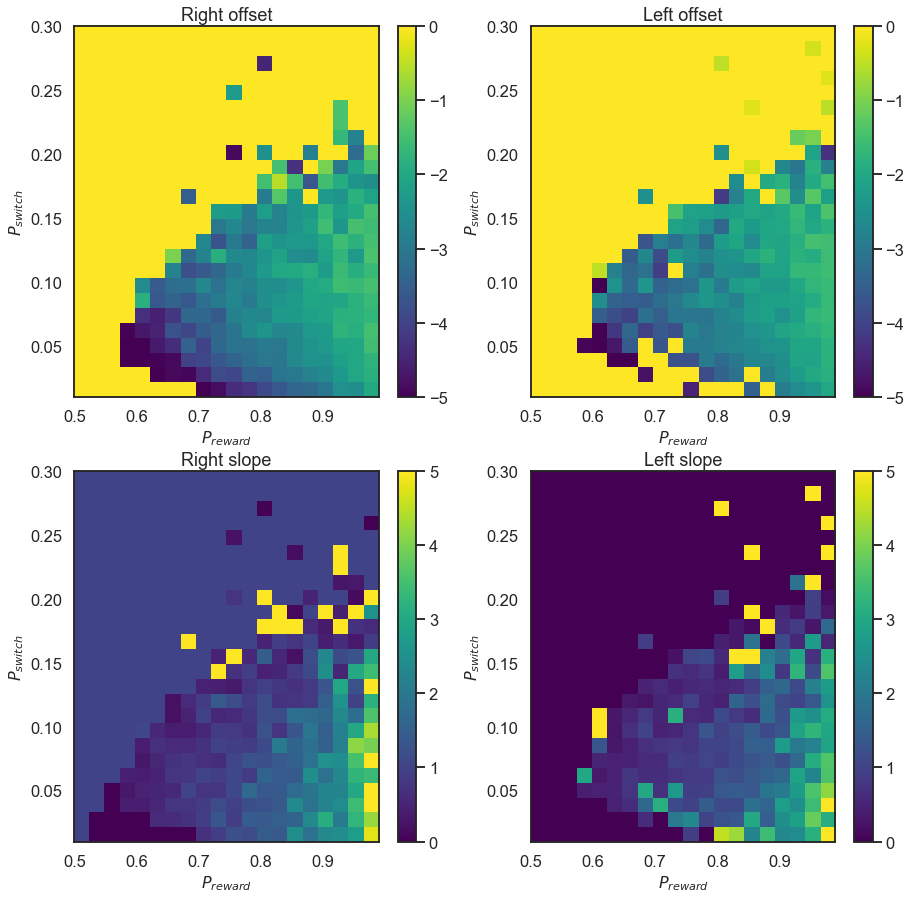

In [349]:
# Plot of foraging efficiency
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.imshow(PRoffsetlist, origin='lower', cmap='viridis', aspect='auto', 
              extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
          vmin=-5, vmax=0)
plt.colorbar()

fontdict = {'fontsize': 16,
 'fontweight': 2}

plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Right offset')


# Plot of transition probability
plt.subplot(222)
plt.imshow(PLoffsetlist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
           vmin=-5, vmax=0
          )
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Left offset')

plt.subplot(223)
plt.imshow(PRslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
          vmin=0, vmax=5)
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Right slope')


plt.subplot(224)
plt.imshow(-PLslopelist, aspect='auto', origin='lower', cmap='viridis',
           extent=[min(prewlst), max(prewlst), min(pswitchlst), max(pswitchlst)],
          vmin=0, vmax=5)
plt.colorbar()
plt.xlabel(r'$P_{reward}$', fontdict)
plt.ylabel(r'$P_{switch}$', fontdict)
plt.title('Left slope')


In [332]:
def find_LR_transition_fit(world, agent, window):
    '''
    For a switching world, determines the agent transition functions,
    for left->right and right->left transitions
    window: how many trials after the transition do we want to keep for fitting?
    '''
    # Find where the block transitions happen
    side_history = np.array(world.side_history)[:,0]
    blocktrans = np.where(np.diff(side_history))[0][:-1]

    # Get the choices around the transition
    choicelst = []
    for i in range(window):
        choicelst.append(np.array(agent.choice_history)[blocktrans + i])

    choicelst = np.array(choicelst)

    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', world.side_history[0][0])
    pRight, pLeft = fit_sigmoidal(choicelst, first_side=world.side_history[0][0])
    return (pRight, pLeft)
    

def fit_sigmoidal(choicelst, first_side):
    '''
    Fit a sigmoidal to the average choice data
    first_side: first side that is rewarded, i.e. world.side_history[0][0]
    '''
    #print('choicemean = ', np.mean(choicelst[:,::2]), 'side=  ', first_side)
    if first_side == 0:
        #print('left')
        leftAverage = np.mean(choicelst[:,::2], axis=1)
        rightAverage = np.mean(choicelst[:,1::2], axis=1)
    else:
        #print('right')
        rightAverage = np.mean(choicelst[:,::2], axis=1)
        leftAverage = np.mean(choicelst[:,1::2], axis=1)

    offsets = np.arange(len(leftAverage))

    # Fit right transitions
    funR = lambda x: errorsigmoid(x, offsets, rightAverage)
    paramsRight = scipy.optimize.minimize(funR, [1,1])
    pRight = paramsRight.x
    
    funL = lambda x: errorsigmoid(x, offsets, leftAverage)
    paramsLeft = scipy.optimize.minimize(funL, [1,1])
    pLeft = paramsLeft.x
    
    return pRight, pLeft

In [95]:
# Find where the block transitions happen
side_history = np.array(world.side_history)[:,0]
blocktrans = np.where(np.diff(side_history))[0]

# Get the choices around the transition
choicelst = []
for i in range(10):
    choicelst.append(np.array(agent.choice_history)[blocktrans + i])
    
choicelst = np.array(choicelst)

# Fit a sigmoidal
if world.side_history[0][0] == 1:
    leftAverage = np.mean(choicelst[:,::2], axis=1)
    rightAverage = np.mean(choicelst[:,1::2], axis=1)
else:
    rightAverage = np.mean(choicelst[:,::2], axis=1)
    leftAverage = np.mean(choicelst[:,1::2], axis=1)

offsets = np.arange(len(leftAverage))

fun = lambda x: errorsigmoid(x, offsets, rightAverage)
paramsRight = scipy.optimize.minimize(fun, [1,1])

pRight = paramsRight.x


# For visualization of fit
# preds = 1 / (1 + np.exp(-p[0] * (offsets + p[1])))
# plt.plot(offsets, preds)
# plt.plot(offsets, rightAverage, '.')

ValueError: Expected 2D array, got 1D array instead:
array=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [180]:
pRight

NameError: name 'pRight' is not defined

In [ ]:
fun = lambda x: errorsigmoid(x, offsets, rightAverage)
params = scipy.optimize.minimize(fun, [1,1])

p = params.x
preds = 1 / (1 + np.exp(-p[0] * (offsets + p[1])))
plt.plot(offsets, preds)
plt.plot(offsets, rightAverage, '.')